In [3]:
!pip install numpy torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

# MNIST dataset (images and labels) as a tensor
dataset = MNIST(root='data/', 
                train=True,
                transform=torchvision.transforms.ToTensor())
len(dataset)

60000

In [ ]:
img_tensor, label = dataset[2]
print(img_tensor.shape, label)
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

torch.Size([1, 28, 28]) 4


In [3]:
## GPU conncet

In [4]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

## Hyperparameters


In [13]:
img_pixels = 28*28
output_option = 10
hidden_size = 32
batch_size = 128
learning_rate = .001
epoch_num = 6

In [14]:
# Preping data

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

train_ds, val_ds = random_split(dataset, [50000, 10000])

print(len(train_ds), len(val_ds))

# Matrix Multiplication is O(n^3) time so it is better to use smaller batches. Data loaders help
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

50000 10000


## Model

In [15]:
class MnistModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size ):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        # # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        # takes a batch and returns the loss
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            # calculate gradients
            loss.backward()
            # change weights
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history
    

In [16]:
model = MnistModel(img_pixels, hidden_size, output_option)

In [17]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3044748306274414, 'val_acc': 0.10472705960273743}

In [18]:
history1 = fit(epoch_num, learning_rate, model, train_loader, val_loader)
history2 = fit(epoch_num, learning_rate, model, train_loader, val_loader)
history3 = fit(epoch_num, learning_rate, model, train_loader, val_loader)
history4 = fit(epoch_num, learning_rate, model, train_loader, val_loader)


Epoch [0], val_loss: 2.2423, val_acc: 0.2364
Epoch [1], val_loss: 2.1691, val_acc: 0.3577
Epoch [2], val_loss: 2.0855, val_acc: 0.4462
Epoch [3], val_loss: 1.9936, val_acc: 0.5121
Epoch [4], val_loss: 1.8937, val_acc: 0.5697
Epoch [5], val_loss: 1.7859, val_acc: 0.6212
Epoch [0], val_loss: 1.6723, val_acc: 0.6651
Epoch [1], val_loss: 1.5565, val_acc: 0.6971
Epoch [2], val_loss: 1.4424, val_acc: 0.7296
Epoch [3], val_loss: 1.3338, val_acc: 0.7513
Epoch [4], val_loss: 1.2336, val_acc: 0.7726
Epoch [5], val_loss: 1.1436, val_acc: 0.7896
Epoch [0], val_loss: 1.0639, val_acc: 0.8015
Epoch [1], val_loss: 0.9942, val_acc: 0.8118
Epoch [2], val_loss: 0.9334, val_acc: 0.8183
Epoch [3], val_loss: 0.8804, val_acc: 0.8259
Epoch [4], val_loss: 0.8342, val_acc: 0.8321
Epoch [5], val_loss: 0.7938, val_acc: 0.8369
Epoch [0], val_loss: 0.7581, val_acc: 0.8419


KeyboardInterrupt: 

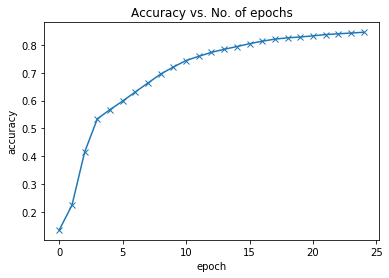

In [15]:
history = [result0] + history1 + history2 + history3 + history4 
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [16]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=torchvision.transforms.ToTensor())

In [39]:
def predict_image(img, model):
    xb = img
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

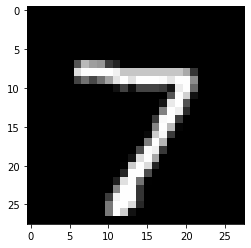

In [40]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))
img

Label: 7 , Predicted: 7


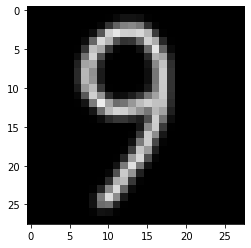

In [50]:
import glob
from PIL import Image
img = Image.open('3test.png')
trans = torchvision.transforms.ToPILImage()
trans1 = torchvision.transforms.ToTensor()

plt.imshow(img)
img = trans1(img)
img.view(img.size(0), -1).shape
print('Label:', label, ', Predicted:', predict_image(img, model))

In [49]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4737306535243988, 'val_acc': 0.88037109375}